# Project Human Language Technology - OffensEval2019
# Task 1
## BERTweet Base
This notebook will explore a model for competition "OffensEval 2019: Identifying and Categorizing Offensive Language in Social Media" using BERTweet Base. \
Matricola: 505252 Michele Morisco

In [1]:
import sys
sys.path.insert(1, '../input/hlt-data/Library/')
dataset_path = '../input/olid-dataset/'
glove_path = '../input/glovetwitter27b100dtxt'

In [2]:
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install emoji --upgrade
!pip install wordsegment
!pip install transformers 
!pip install ekphrasis
!pip install inflect

In [3]:
from PreProcessing import load_dataset
from BERT_TweetBase import run_with_kfold, evaluateFinal
from AnalysisGraph import show_confusion_matrix, show_report, showWrongPredictions

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import string
string.punctuation
import csv
import pandas as pd
import numpy as np

from transformers import AutoModel, AutoTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import torch
from torch import tensor
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

#% matplotlib inline

#Random seed initialization for replicability of results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4
Fri Oct 28 19:52:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00

In [6]:
#SET THE PARAMETERS FOR TRAINING 
H_PARAMETERS = {'model_name': 'vinai/bertweet-base', 'unit_layers' : [768, 64, 32, 2], 'dropout': 0.5, 'folds' : 4, 'batch_size': 4, 
                'warmup_proportion' : 0.1, 'learning_rate': 2e-6, 'loss' : nn.CrossEntropyLoss(), 'num_epochs': 7, 'device' : device}

In [7]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [8]:
data, label = load_dataset(dataset_path = dataset_path)

data.subtask_a.value_counts()

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
user canada need another cuck already enough looney leave liberals fking great country qp roof trudeau must go


NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [9]:
data.tweet.sample(20)

12823                     user good antifa violent fascism
12290    user de create slowly stealthily since conserv...
8474     christian kabasele reveal secrets behind watfo...
4676     user oppose neutral jurist sit scotus weigh me...
397      user wonder apologize diamond silk call minstr...
10957    user know canada want seem enough problems lib...
3311                                        user love maga
12936    user agree still conservatives heart may hate ...
8575                         play water slider summer http
4392     kyky u love u anfield putain la cliiimmmm liv psg
7673     user compromise active investigation sound lik...
12966    fill sky chemicals frequencies ido consent con...
12215    love one another starlight darkness surround m...
5480     verge collapse break wave cannot explain whole...
3535                user hair polyester fibers yoda puppet
4425                           user first regression laugh
5523     user well brandon conservatives get elect red .

In [10]:
X_train = list(data.tweet.values)

In [11]:
MAX_SEQ_LENGTH = 32

tokenizer = AutoTokenizer.from_pretrained(H_PARAMETERS['model_name'], do_lower_case=True)
sentences = data.tweet.values
tokens = tokenizer(X_train, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_train = torch.tensor(tokens['input_ids'])
attention_masks_train  = torch.tensor(tokens['attention_mask'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print('Original: ', sentences[0])
print('Token IDs:', input_ids_train[0])

Original:  user ask native americans take
Token IDs: tensor([    0,  4699,   453,  7468, 29849,   169,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])


In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
test_data, label_test = load_dataset(dataset_path = dataset_path, dataset='testset-levela.tsv', dataset_label='labels-levela.csv')
X_test = list(test_data.tweet.values)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
bigg boss tamil janani task go first final listclapping hand clap hand clap hand clap hand


In [15]:
tokens = tokenizer(X_test, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_test = torch.tensor(tokens['input_ids'])
attention_masks_test  = torch.tensor(tokens['attention_mask'])

test_dataset = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(label_test))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=len(test_dataset))

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.698024   |   0.41    |     -      |     -     |     -     |   2.31   
   1    |   40    |   0.698645   |   0.38    |     -      |     -     |     -     |   1.73   
   1    |   60    |   0.699027   |   0.38    |     -      |     -     |     -     |   1.77   
   1    |   80    |   0.701063   |   0.44    |     -      |     -     |     -     |   1.75   
   1    |   100   |   0.700325   |   0.37    |     -      |     -     |     -     |   1.89   
   1    |   120   |   0.694695 

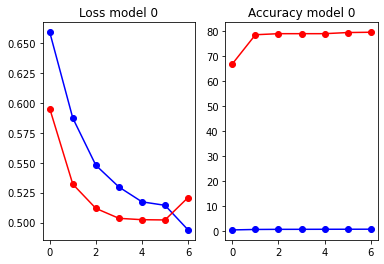

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.698326   |   0.37    |     -      |     -     |     -     |   1.91   
   1    |   40    |   0.704789   |   0.37    |     -      |     -     |     -     |   1.79   
   1    |   60    |   0.700806   |   0.38    |     -      |     -     |     -     |   1.78   
   1    |   80    |   0.706767   |   0.33    |     -      |     -     |     -     |   1.91   
   1    |   100   |   0.694929   |   0.40    |     -      |     -     |     -     |   1.78   
   1    |   120   |   0.704728 

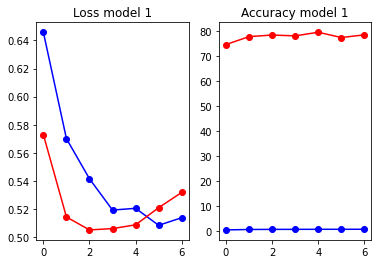

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.715458   |   0.28    |     -      |     -     |     -     |   1.86   
   1    |   40    |   0.717587   |   0.25    |     -      |     -     |     -     |   1.91   
   1    |   60    |   0.716068   |   0.22    |     -      |     -     |     -     |   1.75   
   1    |   80    |   0.718240   |   0.22    |     -      |     -     |     -     |   1.75   
   1    |   100   |   0.717611   |   0.26    |     -      |     -     |     -     |   1.87   
   1    |   120   |   0.702229 

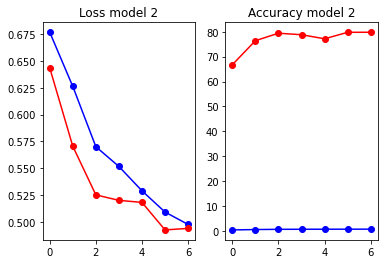

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.696825   |   0.36    |     -      |     -     |     -     |   1.89   
   1    |   40    |   0.685924   |   0.43    |     -      |     -     |     -     |   1.79   
   1    |   60    |   0.687929   |   0.46    |     -      |     -     |     -     |   1.77   
   1    |   80    |   0.680757   |   0.51    |     -      |     -     |     -     |   1.77   
   1    |   100   |   0.671664   |   0.50    |     -      |     -     |     -     |   1.78   
   1    |   120   |   0.670234 

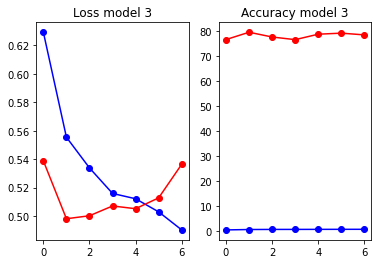

------RESULT------


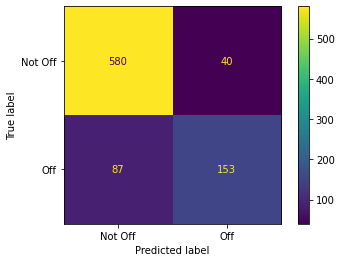

              precision    recall  f1-score   support

     Not Off     0.8696    0.9355    0.9013       620
         Off     0.7927    0.6375    0.7067       240

    accuracy                         0.8523       860
   macro avg     0.8312    0.7865    0.8040       860
weighted avg     0.8481    0.8523    0.8470       860

f1_score test tweets: 0.8040091804525986


In [16]:
models, preds_ensemble = run_with_kfold(input_ids_train, attention_masks_train, test_dataloader, torch.tensor(label), label_test, H_PARAMETERS)

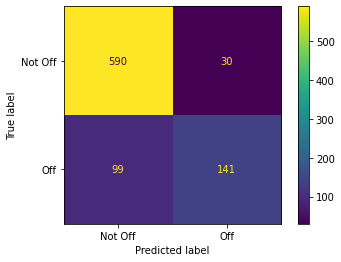

              precision    recall  f1-score   support

     Not Off     0.8563    0.9516    0.9015       620
         Off     0.8246    0.5875    0.6861       240

    accuracy                         0.8500       860
   macro avg     0.8404    0.7696    0.7938       860
weighted avg     0.8475    0.8500    0.8414       860

Bert model 0 tweets testset result => Loss: 0.4203186333179474 Accuracy: 85.0 F1 score: 79.37914382740487


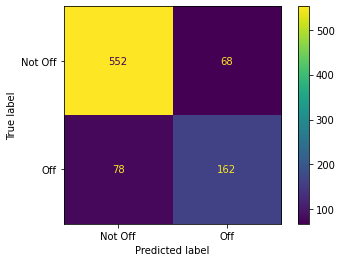

              precision    recall  f1-score   support

     Not Off     0.8762    0.8903    0.8832       620
         Off     0.7043    0.6750    0.6894       240

    accuracy                         0.8302       860
   macro avg     0.7903    0.7827    0.7863       860
weighted avg     0.8282    0.8302    0.8291       860

Bert model 1 tweets testset result => Loss: 0.44262874126434326 Accuracy: 83.02325581395348 F1 score: 78.62808510638297


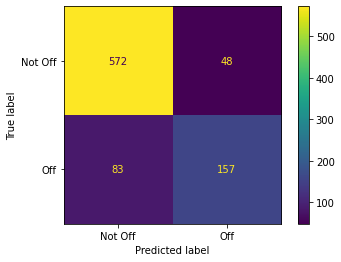

              precision    recall  f1-score   support

     Not Off     0.8733    0.9226    0.8973       620
         Off     0.7659    0.6542    0.7056       240

    accuracy                         0.8477       860
   macro avg     0.8196    0.7884    0.8014       860
weighted avg     0.8433    0.8477    0.8438       860

Bert model 2 tweets testset result => Loss: 0.41492989659309387 Accuracy: 84.76744186046513 F1 score: 80.1436439744437


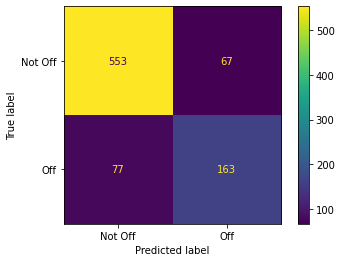

              precision    recall  f1-score   support

     Not Off     0.8778    0.8919    0.8848       620
         Off     0.7087    0.6792    0.6936       240

    accuracy                         0.8326       860
   macro avg     0.7932    0.7856    0.7892       860
weighted avg     0.8306    0.8326    0.8314       860

Bert model 3 tweets testset result => Loss: 0.44298815727233887 Accuracy: 83.25581395348837 F1 score: 78.92085106382979


In [17]:
for i in range(len(models)):
  models[i].to(device)
  val_loss, val_accuracys, f1_value_tweets = evaluateFinal(models[i], test_dataloader, H_PARAMETERS['device'], H_PARAMETERS['loss'])
  models[i].to('cpu')
  print("Bert model {0} tweets testset result => Loss: {1} Accuracy: {2} F1 score: {3}".format(i, val_loss, val_accuracys, f1_value_tweets))

In [18]:
showWrongPredictions(test_data, torch.tensor(label), preds_ensemble)

       id                   tweet
14  12588  user nigga ware da hit
       id                                   tweet
15  34263  stop kavanaugh liar like rest gop http
       id                                              tweet
27  49139  user put delauro police lineup identify bag la...
       id                                              tweet
38  46444  ariana asesina serious holy shit please fuck a...
       id                             tweet
39  60587  user hide ugly personality worst
      id                                              tweet
1  27014  constitution day revere conservatives hat prog...
      id                                              tweet
3  13876  watch boomer get news still parole always make...
      id                                              tweet
6  96874  rap form art use express freely gv green light...
      id                                      tweet
7  65507  user get feel kiss behind humiliate later
      id                            